## Neural Network models - Leave One Participant Out CV to predict properties using 3 subwindows

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim



In [2]:
# Initialise the random state
#num = random.randint(1, 500)
num = 58
torch.manual_seed(num)
np.random.seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 58


### Load data

In [5]:
import os

In [9]:
os.getcwd()

'/Users/albyscotney/Desktop/nini'

In [11]:
path = "complete_dataset_15subwindows_3slices.csv"
df = pd.read_csv(path)
df.head(10)

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,7,14,0,smoothness,1,3,medium,2,1,1,0.500000,0.620513,0.675978,0.495868,0.759036,0.652406,0.76250,0.666667,0.497558,0.612908,0.665979,0.492323,0.718373,0.636455,0.748970,0.661048,0.002307,0.002685,0.003138,0.002326,0.007215,0.004555,0.003543,0.002655,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.648515,0.576037,0.497131,0.848195,0.691944,0.635252,0.491607,0.526964,0.597308,0.558093,0.003403,0.011867,0.012139,0.020191,0.002323,0.156897,0.015387,0.005509,-0.852173,-0.068771,0.481033,0.000330,0.000281,0.000349,0.906808,0.944010,1.878005,-0.863647,-0.092331,0.468185,-0.000014,0.000033,-0.000021,0.018182,0.033422,0.090670,0.006859,0.010176,0.008799,0.000187,0.000229,0.000238,0.488839,0.644995,0.731794,0.992020,0.013489,-0.198410,0.001218,0.000510,0.001187,1.448006,1.255580,2.343750,0.970749,-0.013306,-0.239548,3.040000e-05,-0.000022,0.000121,0.039065,-0.063439,0.154164,0.016338,0.011627,0.024494,0.000461,0.000354,0.000641,0.865981,0.887638,1.211894,0.179352,0.486364,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574502,268.044509,1338.775861,0.176140,0.485378,0.158694,-0.841542,-0.003855,-0.006977,-0.063971,-0.440979,0.013134,-0.200017,-49.406882,-39.838054,68.564941,0.002032,0.000740,0.001425,0.000338,0.053708,0.033528,0.137260,2.915747,1.852018,9.040299,366.140398,183.977327,777.818352,0.613327,-0.175326,-0.758505,-0.128901,0.14007

In [12]:
# Remove enjoyment as we are only considering physical properties
print(df.shape)
physical_df = df[df.property_name!='enjoyment']
physical_df.shape

(22679, 190)


(18899, 190)

In [13]:
physical_df.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,7,14,0,smoothness,1,3,medium,2,1,1,0.500000,0.620513,0.675978,0.495868,0.759036,0.652406,0.76250,0.666667,0.497558,0.612908,0.665979,0.492323,0.718373,0.636455,0.748970,0.661048,0.002307,0.002685,0.003138,0.002326,0.007215,0.004555,0.003543,0.002655,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.648515,0.576037,0.497131,0.848195,0.691944,0.635252,0.491607,0.526964,0.597308,0.558093,0.003403,0.011867,0.012139,0.020191,0.002323,0.156897,0.015387,0.005509,-0.852173,-0.068771,0.481033,0.000330,0.000281,0.000349,0.906808,0.944010,1.878005,-0.863647,-0.092331,0.468185,-0.000014,0.000033,-0.000021,0.018182,0.033422,0.090670,0.006859,0.010176,0.008799,0.000187,0.000229,0.000238,0.488839,0.644995,0.731794,0.992020,0.013489,-0.198410,0.001218,0.000510,0.001187,1.448006,1.255580,2.343750,0.970749,-0.013306,-0.239548,0.000030,-0.000022,0.000121,0.039065,-0.063439,0.154164,0.016338,0.011627,0.024494,0.000461,0.000354,0.000641,0.865981,0.887638,1.211894,0.179352,0.486364,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574502,268.044509,1338.775861,0.176140,0.485378,0.158694,-0.841542,-0.003855,-0.006977,-0.063971,-0.440979,0.013134,-0.200017,-49.406882,-39.838054,68.564941,0.002032,0.000740,0.001425,0.000338,0.053708,0.033528,0.137260,2.915747,1.852018,9.040299,366.140398,183.977327,777.818352,0.613327,-0.175326,-0.758505,-0.128901,0.140072,0.

### Normalise the data

In [14]:
starting_index = 10
# Obtain a df of features
features_df = physical_df.iloc[:,starting_index:]
features_df.head()


,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1,max_Ax_hand0,max_Ay_hand0,max_Az_hand0,max_Vx_hand0,max_Vy_hand0,max_Vz_hand0,max_Jx_hand0,max_Jy_hand0,max_Jz_hand0,mean_Ax_hand0,mean_Ay_hand0,mean_Az_hand0,mean_Vx_hand0,mean_Vy_hand0,mean_Vz_hand0,mean_Jx_hand0,mean_Jy_hand0,mean_Jz_hand0,std_Ax_hand0,std_Ay_hand0,std_Az_hand0,std_Vx_hand0,std_Vy_hand0,std_Vz_hand0,std_Jx_hand0,std_Jy_hand0,std_Jz_hand0,max_Ax_hand1,max_Ay_hand1,max_Az_hand1,max_Vx_hand1,max_Vy_hand1,max_Vz_hand1,max_Jx_hand1,max_Jy_hand1,max_Jz_hand1,mean_Ax_hand1,mean_Ay_hand1,mean_Az_hand1,mean_Vx_hand1,mean_Vy_hand1,mean_Vz_hand1,mean_Jx_hand1,mean_Jy_hand1,mean_Jz_hand1,std_Ax_hand1,std_Ay_hand1,std_Az_hand1,std_Vx_hand1,std_Vy_hand1,std_Vz_hand1,std_Jx_hand1,std_Jy_hand1,std_Jz_hand1,max_w_hand0,max_x_hand0,max_y_hand0,max_z_hand0,max_AVx_hand0,max_AVy_hand0,max_AVz_hand0,max_AAx_hand0,max_AAy_hand0,max_AAz_hand0,max_AJx_hand0,max_AJy_hand0,max_AJz_hand0,mean_w_hand0,mean_x_hand0,mean_y_hand0,mean_z_hand0,mean_AVx_hand0,mean_AVy_hand0,mean_AVz_hand0,mean_AAx_hand0,mean_AAy_hand0,mean_AAz_hand0,mean_AJx_hand0,mean_AJy_hand0,mean_AJz_hand0,std_w_hand0,std_x_hand0,std_y_hand0,std_z_hand0,std_AVx_hand0,std_AVy_hand0,std_AVz_hand0,std_AAx_hand0,std_AAy_hand0,std_AAz_hand0,std_AJx_hand0,std_AJy_hand0,std_AJz_hand0,max_w_hand1,max_x_hand1,max_y_hand1,max_z_hand1,max_AVx_hand1,max_AVy_hand1,max_AVz_hand1,max_AAx_hand1,max_AAy_hand1,max_AAz_hand1,max_AJx_hand1,max_AJy_hand1,max_AJz_hand1,mean_w_hand1,mean_x_hand1,mean_y_hand1,mean_z_hand1,mean_AVx_hand1,mean_AVy_hand1,mean_AVz_hand1,mean_AAx_hand1,mean_AAy_hand1,mean_AAz_hand1,mean_AJx_hand1,mean_AJy_hand1,mean_AJz_hand1,std_w_hand1,std_x_hand1,std_y_hand1,std_z_hand1,std_AVx_hand1,std_AVy_hand1,std_AVz_hand1,std_AAx_hand1,std_AAy_hand1,std_AAz_hand1,std_AJx_hand1,std_AJy_hand1,std_AJz_hand1
0,0.500000,0.620513,0.675978,0.495868,0.759036,0.652406,0.76250,0.666667,0.497558,0.612908,0.665979,0.492323,0.718373,0.636455,0.748970,0.661048,0.002307,0.002685,0.003138,0.002326,0.007215,0.004555,0.003543,0.002655,0.508197,0.929578,0.757225,0.730159,0.497959,0.995918,0.648515,0.576037,0.497131,0.848195,0.691944,0.635252,0.491607,0.526964,0.597308,0.558093,0.003403,0.011867,0.012139,0.020191,0.002323,0.156897,0.015387,0.005509,-0.852173,-0.068771,0.481033,0.000330,0.000281,0.000349,0.906808,0.944010,1.878005,-0.863647,-0.092331,0.468185,-0.000014,0.000033,-0.000021,0.018182,0.033422,0.090670,0.006859,0.010176,0.008799,0.000187,0.000229,0.000238,0.488839,0.644995,0.731794,0.992020,0.013489,-0.198410,0.001218,0.000510,0.001187,1.448006,1.255580,2.343750,0.970749,-0.013306,-0.239548,0.000030,-0.000022,0.000121,0.039065,-0.063439,0.154164,0.016338,0.011627,0.024494,0.000461,0.000354,0.000641,0.865981,0.887638,1.211894,0.179352,0.486364,0.160615,-0.840857,0.133141,0.061469,0.117029,4.332320,2.887801,19.812834,554.574502,268.044509,1338.775861,0.176140,0.485378,0.158694,-0.841542,-0.003855,-0.006977,-0.063971,-0.440979,0.013134,-0.200017,-49.406882,-39.838054,68.564941,0.002032,0.000740,0.001425,0.000338,0.053708,0.033528,0.137260,2.915747,1.852018,9.040299,366.140398,183.977327,777.818352,0.613327,-0.175326,-0.758505,-0.128901,0.140072,0.440644,0.126734,5.745156,20.612016,10.404938,649.805789,1527.420437,579.105295,0.602803,-0.176687,-0.767038,-0.130432,0.044346,0.166936,-0.015194,0.369931,0.966866,

In [15]:
normalised_features_df = features_df.copy()
print(normalised_features_df.shape)

(18899, 180)


In [16]:
# create scaler
scaler = MinMaxScaler(feature_range=(-1,1)) # As this is the range of the activation function - tanh

# fit scaler and apply transform
normalised_features_df[normalised_features_df.columns] = scaler.fit_transform(features_df[features_df.columns])
normalised_features_df.shape

(18899, 180)

In [17]:
df_info = physical_df.iloc[:, :starting_index]
df_info.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num
0,7,14,0,smoothness,1,3,medium,2,1,1
1,7,14,0,smoothness,1,3,medium,2,1,2
2,7,14,0,smoothness,1,3,medium,2,1,3
3,7,14,0,smoothness,1,3,medium,2,2,1
4,7,14,0,smoothness,1,3,medium,2,2,2


In [18]:
normalised_df = pd.concat([df_info,normalised_features_df], axis=1)
normalised_df.shape

(18899, 190)

### Create X and y data

In [19]:
def create_X_2d(df, features_starting_idx):
    
    X_2d = df.iloc[:,features_starting_idx:].values
    
    X_tensor_2d = torch.Tensor(X_2d)    
    return X_tensor_2d



In [20]:
def create_y_train_for_2d_X(df, predicting_feature = 'property_id', output_as_tensor='Yes'):
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    if output_as_tensor == 'Yes':
        # Convert to a tensor
        y_train = torch.Tensor(y_train)

    return y_train



In [21]:
def create_y_test_for_2d_X(df, predicting_feature = 'property_id'):   
    y_test = df[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test_tensor = torch.Tensor(y_test)    
    y_test_tensor = y_test_tensor.type(torch.LongTensor)
    
    return y_test_tensor


In [22]:
def create_X_3d(df, features_starting_idx):
    dim1 = df.new_interaction_id.nunique()
    print(dim1)
    dim2 = df.slice_num.nunique()
    dim3 = df.iloc[:,features_starting_idx:].shape[1]
        
    X = np.zeros((dim1, dim2, dim3)) 

    itr_id_lst = df.new_interaction_id.unique().tolist()
    print(itr_id_lst[0], itr_id_lst[-1])

    for itr_id in itr_id_lst: #range(len(itr_id_lst)):
        #itr_id = itr_id_lst[i]
        itr_id_df = df[df.new_interaction_id==itr_id]  
        
        for j in range(itr_id_df.shape[0]):
            vals_arr = itr_id_df.iloc[j,features_starting_idx:].values
            if itr_id-1 == dim1:
                print(itr_id)
            X[itr_id-1,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor


In [23]:
def create_y_train_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train



In [24]:
def create_y_test_for_3d_X(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['new_interaction_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    #if predicting_feature == 'property_id':
       # y_test = y_test - 3
    if predicting_feature == 'rating_level_num':
        y_test = y_test - 1
    
    y_test = torch.Tensor(y_test)    
    y_test = y_test.type(torch.LongTensor)
    
    return y_test



## Model 1 - Linear model using all 180 features

### Create the model

In [25]:
class Linear_all_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(180, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class Linear_all_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(185, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)        

    def forward(self, x): #, x2
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
 

In [30]:
def find_best_model_for_2d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model):

    # Model
    train_model = model

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#
            #print(train_preds)
            #print(train_labels)
            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        # Commented out
        if epoch % 10 == 0:
            print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [31]:
# Original
def Linear_LOP0CV(data, model, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    #macro_f1_lst = []
    acc_lst = []
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = []    



    #lst = [6,24]
    
    for participant in sorted(data.participant_id.unique()): #lst: #:
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        X_train = create_X_2d(training_data, 10)       
        y_train = create_y_train_for_2d_X(training_data, predicting_feature = predicting_feature, output_as_tensor='Yes')
        X_test = create_X_2d(testing_data, 10) 
        y_test = create_y_test_for_2d_X(testing_data, predicting_feature = predicting_feature)
        
        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
        #print('------------')
        
        if predicting_feature == 'rating_level_num':
            X_train_add = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id', output_as_tensor='Yes')
            #X_train_add = torch.Tensor(X_train_add)    
            #print(type(X_train_add))
            #print(type(X_train))
            X_train = torch.cat((X_train_add, X_train), 1)
            #X_train = pd.concat([X_train_add, X_train], axis=1)
            X_test_add = create_y_train_for_2d_X(testing_data, predicting_feature = 'property_id', output_as_tensor='Yes')
            #X_test_add = torch.Tensor(X_test_add)   
            X_test = torch.cat((X_test_add, X_test), 1)

        
        #print(X_train.shape)
        #print(y_train)
        #print(X_test.shape)
        #print(y_test.shape[0]//4)

        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=y_test.shape[0]//4) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
           # print(train_ids)
            #print(val_ids)
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_2d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = model
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
               
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
            macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0,1,2])
            weighted_f1_score = f1_score(test_labels_np, test_predicted_np, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score)
            
        total_conf_mat += conf_mat
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(test_labels_np, test_predicted_np)
        acc_lst.append(acc)


        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}") 
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)  
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)             
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            





### Run the model for properties

In [32]:
t1 = time.time()

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.6, val loss = 1.56, average loss = 1.58
epoch 11: train loss = 1.47, val loss = 1.46, average loss = 1.47
epoch 21: train loss = 1.43, val loss = 1.41, average loss = 1.42
epoch 31: train loss = 1.42, val loss = 1.44, average loss = 1.43
epoch 41: train loss = 1.42, val loss = 1.4, average loss = 1.41
epoch 51: train loss = 1.43, val loss = 1.43, average loss = 1.43
epoch 61: train loss = 1.42, val loss = 1.4, average loss = 1.41
FOLD 2:
epoch 1: train loss = 1.41, val loss = 1.38, average loss = 1.39
epoch 11: train loss = 1.43, val loss = 1.38, average loss = 1.41
epoch 21: train loss = 1.42, val loss = 1.45, average loss = 1.43
epoch 31: train loss = 1.41, val loss = 1.39, average loss = 1.4
epoch 41: train loss = 1.41, val loss = 1.39, average loss = 1.4
epoch 51: train loss = 1.4, val loss = 1.4, average loss = 1.4
epoch 61: train loss = 1.41, val loss = 1.39, average loss = 1.4
FOLD 3:
epoch 1: train loss = 1.4, val loss 

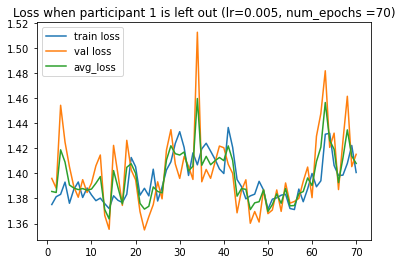

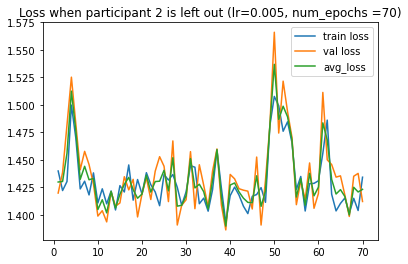

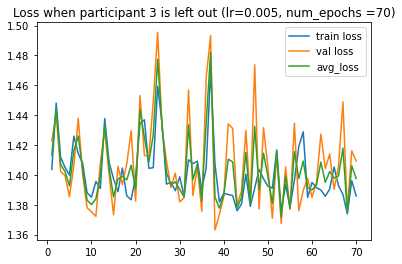

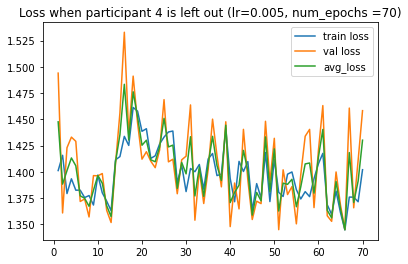

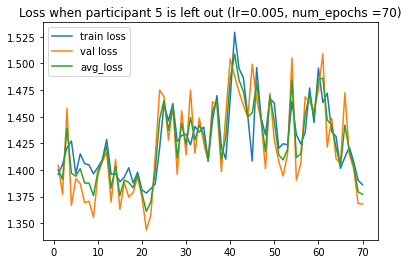

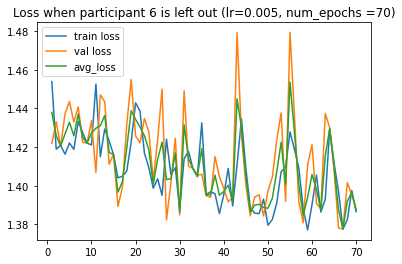

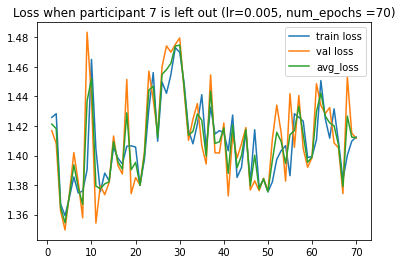

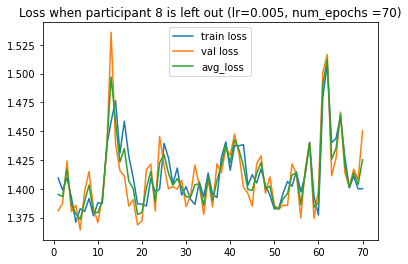

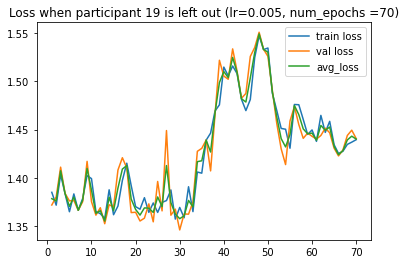

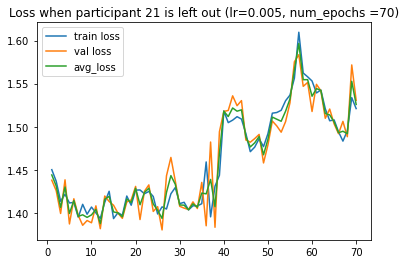

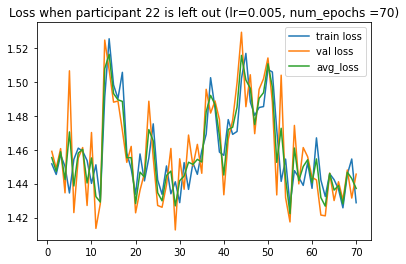

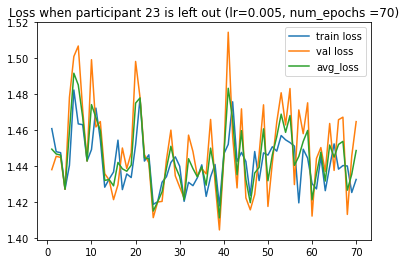

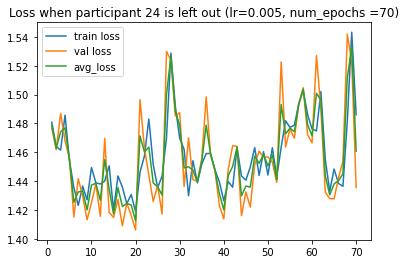

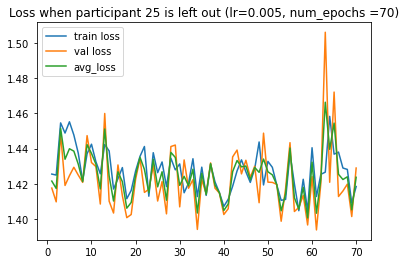

In [33]:
Linear_LOP0CV(normalised_df, model=Linear_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=70, random_state=num)
    

In [34]:
t2 = time.time()

In [35]:
#Linear_LOP0CV(normalised_df, model=Linear_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=150, random_state=num)


### Run the model for ratings

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.02, val loss = 1.0, average loss = 1.01
epoch 11: train loss = 0.9, val loss = 0.89, average loss = 0.9
epoch 21: train loss = 0.9, val loss = 0.93, average loss = 0.91
epoch 31: train loss = 0.88, val loss = 0.89, average loss = 0.89
epoch 41: train loss = 0.87, val loss = 0.87, average loss = 0.87
FOLD 2:
epoch 1: train loss = 0.9, val loss = 0.87, average loss = 0.89
epoch 11: train loss = 0.91, val loss = 0.88, average loss = 0.89
epoch 21: train loss = 0.88, val loss = 0.91, average loss = 0.89
epoch 31: train loss = 0.87, val loss = 0.86, average loss = 0.86
epoch 41: train loss = 0.87, val loss = 0.88, average loss = 0.87
FOLD 3:
epoch 1: train loss = 0.86, val loss = 0.86, average loss = 0.86
epoch 11: train loss = 0.87, val loss = 0.86, average loss = 0.86
epoch 21: train loss = 0.85, val loss = 0.86, average loss = 0.85
epoch 31: train loss = 0.86, val loss = 0.85, average loss = 0.85
epoch 41: train loss = 0.85, val 

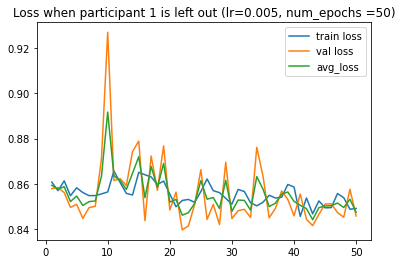

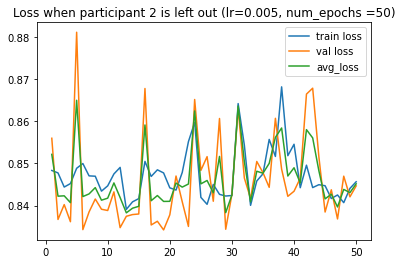

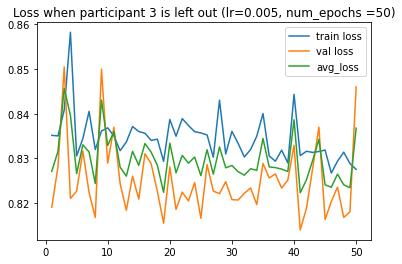

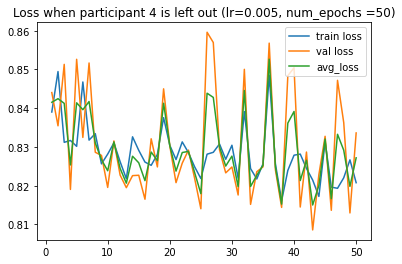

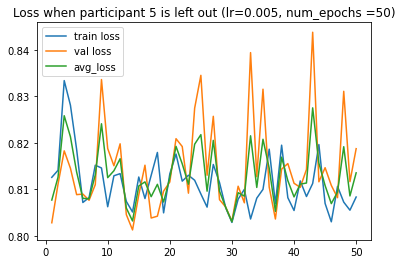

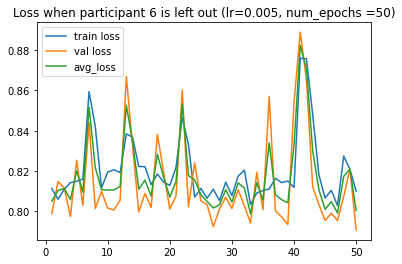

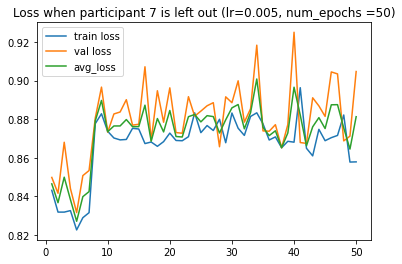

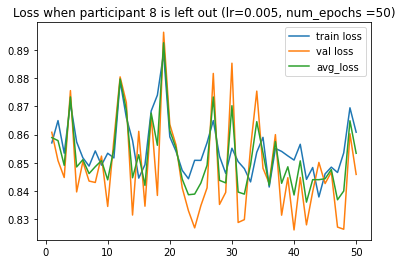

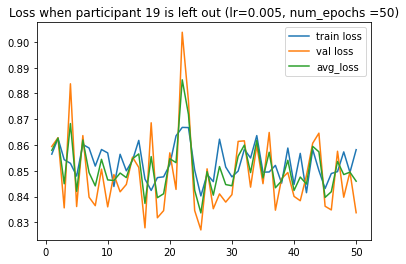

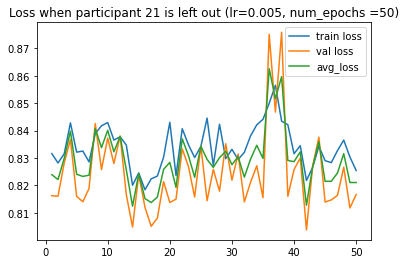

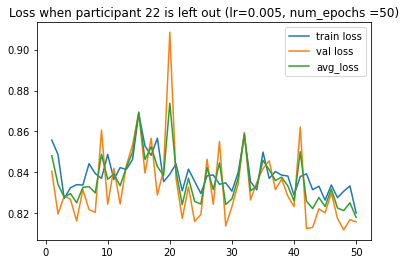

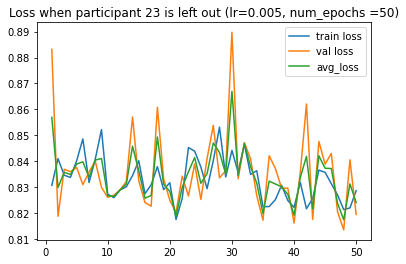

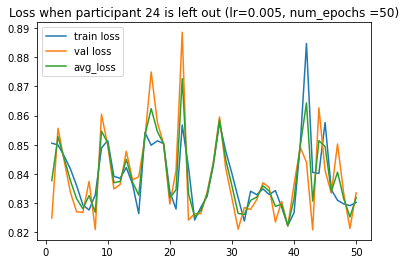

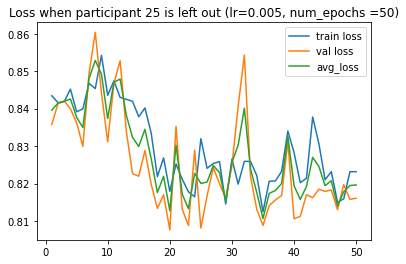

In [36]:
Linear_LOP0CV(normalised_df, model=Linear_all_features_ratings(), num_folds=3, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num)
#rating_level_num


## Model 2 - Linear model using only the emg data (48 features)

In [37]:
complete_emg = normalised_df.iloc[:,:58]
complete_emg.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,rating,rating_level,rating_level_num,sub_window_num,slice_num,max_ch1_hand0,max_ch2_hand0,max_ch3_hand0,max_ch4_hand0,max_ch5_hand0,max_ch6_hand0,max_ch7_hand0,max_ch8_hand0,mean_ch1_hand0,mean_ch2_hand0,mean_ch3_hand0,mean_ch4_hand0,mean_ch5_hand0,mean_ch6_hand0,mean_ch7_hand0,mean_ch8_hand0,std_ch1_hand0,std_ch2_hand0,std_ch3_hand0,std_ch4_hand0,std_ch5_hand0,std_ch6_hand0,std_ch7_hand0,std_ch8_hand0,max_ch1_hand1,max_ch2_hand1,max_ch3_hand1,max_ch4_hand1,max_ch5_hand1,max_ch6_hand1,max_ch7_hand1,max_ch8_hand1,mean_ch1_hand1,mean_ch2_hand1,mean_ch3_hand1,mean_ch4_hand1,mean_ch5_hand1,mean_ch6_hand1,mean_ch7_hand1,mean_ch8_hand1,std_ch1_hand1,std_ch2_hand1,std_ch3_hand1,std_ch4_hand1,std_ch5_hand1,std_ch6_hand1,std_ch7_hand1,std_ch8_hand1
0,7,14,0,smoothness,1,3,medium,2,1,1,0.000000,0.241026,0.351956,-0.008264,0.518072,0.304812,0.5250,0.333334,0.106446,0.458069,0.600224,0.328286,0.763818,0.600703,0.952406,0.569367,-0.989579,-0.970262,-0.979567,-0.987704,-0.961911,-0.973839,-0.977602,-0.980363,0.016394,0.859156,0.514450,0.460318,-0.004082,0.991836,0.297030,0.152074,0.257107,0.995134,0.749178,0.696744,0.291791,0.497051,0.440943,0.297865,-0.978453,-0.920148,-0.769635,-0.721283,-0.988758,-0.135255,-0.854100,-0.955585
1,7,14,0,smoothness,1,3,medium,2,1,2,0.008264,0.230770,0.351956,-0.008264,0.493976,0.304812,0.5250,0.333334,0.106535,0.457327,0.599751,0.328514,0.764280,0.602491,0.951629,0.568445,-0.989229,-0.968885,-0.980203,-0.988803,-0.969074,-0.976084,-0.974391,-0.980466,0.008196,0.760564,0.479768,0.354498,-0.012244,0.575510,0.277228,0.152074,0.256530,0.994936,0.749071,0.695700,0.291602,0.452270,0.439619,0.297396,-0.982842,-0.952588,-0.821947,-0.837338,-0.989331,-0.380445,-0.884059,-0.959461
2,7,14,0,smoothness,1,3,medium,2,1,3,0.000000,0.241026,0.340782,0.000000,0.481928,0.304812,0.5125,0.333334,0.105977,0.457861,0.600071,0.327780,0.764491,0.602384,0.952221,0.567943,-0.989589,-0.969031,-0.981343,-0.988636,-0.971692,-0.976385,-0.978975,-0.981760,0.016394,0.816902,0.514450,0.428572,-0.004082,0.428572,0.326732,0.161290,0.257472,0.997383,0.750233,0.694737,0.291724,0.414584,0.438194,0.297822,-0.980656,-0.931014,-0.771042,-0.785107,-0.988695,-0.436072,-0.850588,-0.961268
3,7,14,0,smoothness,1,3,medium,2,2,1,0.000000,0.241026,0.351956,-0.008264,0.518072,0.326204,0.5125,0.333334,0.106191,0.457861,0.600590,0.327887,0.764558,0.602323,0.952239,0.567456,-0.989989,-0.967511,-0.981089,-0.989723,-0.966768,-0.976261,-0.982523,-0.980699,0.016394,0.859156,0.618498,0.322752,-0.012244,0.640816,0.247524,0.142858,0.256395,0.995652,0.749179,0.692946,0.290316,0.350005,0.437136,0.297463,-0.982005,-0.934272,-0.759036,-0.915227,-0.989146,-0.283615,-0.926506,-0.963167
4,7,14,0,smoothness,1,3,medium,2,2,2,0.008264,0.241026,0.351956,0.000000,0.493976,0.304812,0.5125,0.333334,0.105846,0.458242,0.600506,0.328723,0.764373,0.602575,0.951527,0.568528,-0.989113,-0.970855,-0.982114,-0.986610,-0.962694,-0.971898,-0.978897,-0.980697,0.016394,0.915492,0.618498,0.492064,-0.004082,0.991836,0.366336,0.152074,0.256824,0.997948,0.754550,0.697788,0.291541,0.367741,0.444030,0.298248,-0.973323,-0.879495,-0.492333,-0.674262,-0.989347,0.371875,-0.799849,-0.953724


### Create the model

In [38]:
class Linear_emg_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)        
           
    def forward(self, x): #, x2
        #print(x.shape)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

class Linear_emg_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(48+5, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 3)        

    def forward(self, x): #, x2
        #print(x.shape)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


### Run the model for properties

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.61, val loss = 1.61, average loss = 1.61
epoch 11: train loss = 1.54, val loss = 1.56, average loss = 1.55
epoch 21: train loss = 1.5, val loss = 1.51, average loss = 1.51
epoch 31: train loss = 1.48, val loss = 1.48, average loss = 1.48
epoch 41: train loss = 1.47, val loss = 1.49, average loss = 1.48
FOLD 2:
epoch 1: train loss = 1.47, val loss = 1.44, average loss = 1.46
epoch 11: train loss = 1.46, val loss = 1.43, average loss = 1.45
epoch 21: train loss = 1.44, val loss = 1.45, average loss = 1.44
epoch 31: train loss = 1.44, val loss = 1.44, average loss = 1.44
epoch 41: train loss = 1.44, val loss = 1.42, average loss = 1.43
FOLD 3:
epoch 1: train loss = 1.44, val loss = 1.42, average loss = 1.43
epoch 11: train loss = 1.43, val loss = 1.42, average loss = 1.43
epoch 21: train loss = 1.43, val loss = 1.43, average loss = 1.43
epoch 31: train loss = 1.43, val loss = 1.46, average loss = 1.44
epoch 41: train loss = 1.42, 

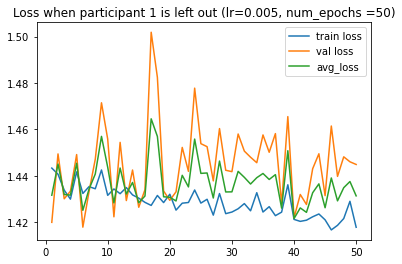

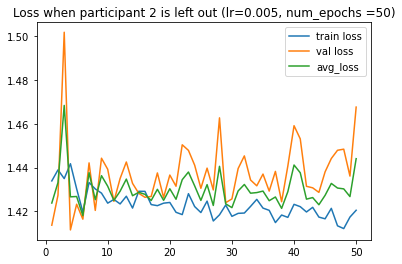

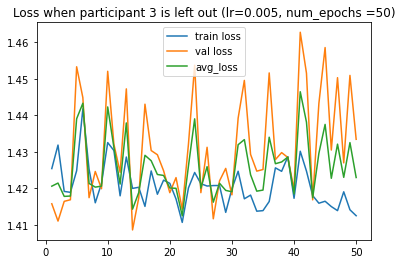

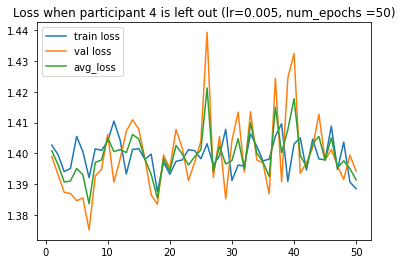

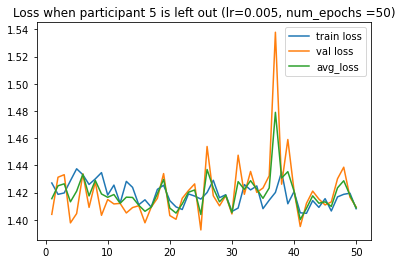

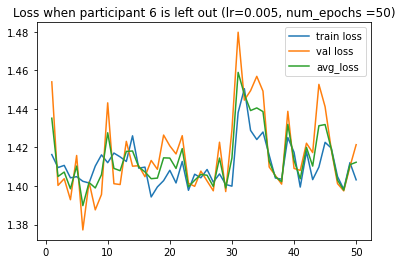

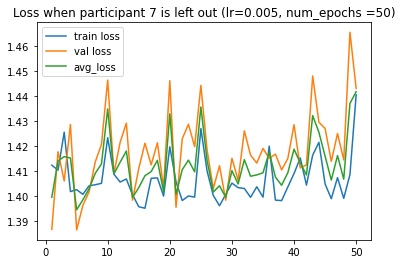

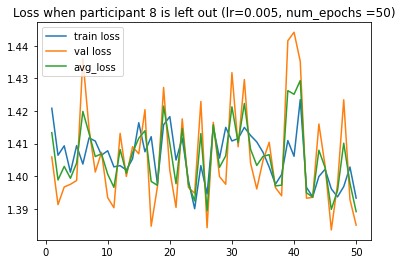

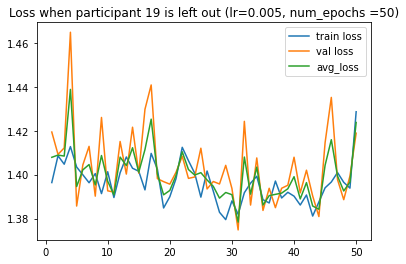

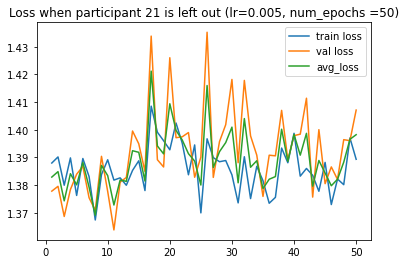

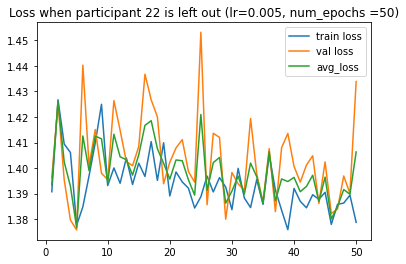

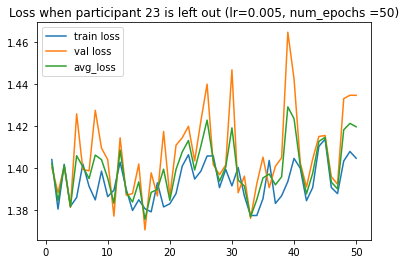

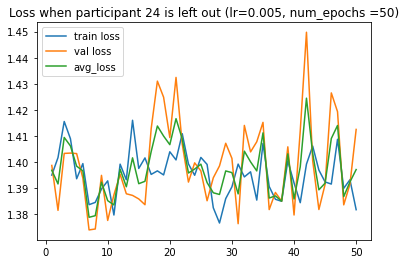

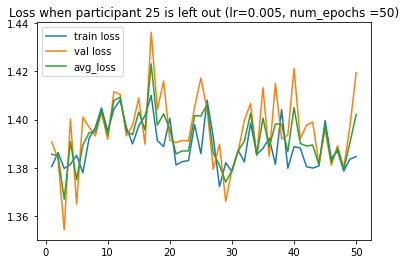

In [39]:
Linear_LOP0CV(complete_emg, model=Linear_emg_features_properties(), num_folds=3, predicting_feature='property_id', learning_rate=0.005, num_epochs=50, random_state=num)


### Run the model for ratings

LEAVING PARTICIPANT 1 OUT:
FOLD 1:
epoch 1: train loss = 1.01, val loss = 0.99, average loss = 1.0
epoch 11: train loss = 0.92, val loss = 0.94, average loss = 0.93
epoch 21: train loss = 0.9, val loss = 0.92, average loss = 0.91
epoch 31: train loss = 0.9, val loss = 0.91, average loss = 0.9
epoch 41: train loss = 0.89, val loss = 0.9, average loss = 0.89
FOLD 2:
epoch 1: train loss = 0.89, val loss = 0.87, average loss = 0.88
epoch 11: train loss = 0.88, val loss = 0.89, average loss = 0.88
epoch 21: train loss = 0.88, val loss = 0.87, average loss = 0.88
epoch 31: train loss = 0.88, val loss = 0.87, average loss = 0.87
epoch 41: train loss = 0.87, val loss = 0.87, average loss = 0.87
FOLD 3:
epoch 1: train loss = 0.87, val loss = 0.87, average loss = 0.87
epoch 11: train loss = 0.87, val loss = 0.88, average loss = 0.87
epoch 21: train loss = 0.87, val loss = 0.87, average loss = 0.87
epoch 31: train loss = 0.87, val loss = 0.87, average loss = 0.87
epoch 41: train loss = 0.86, val 

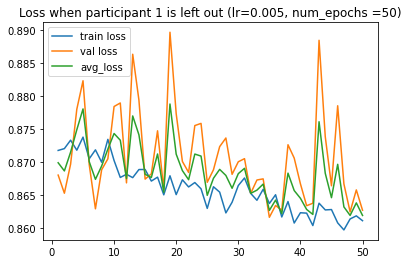

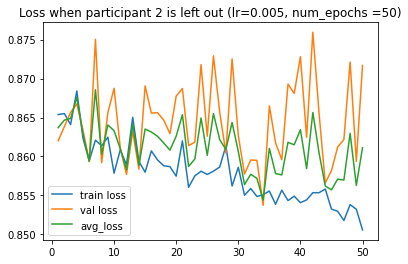

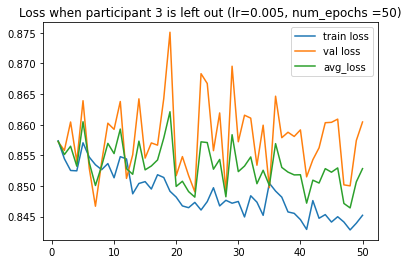

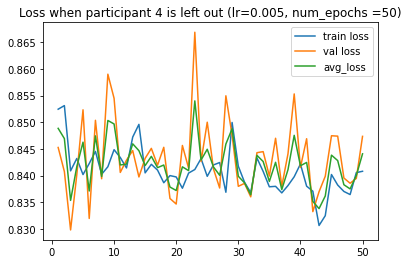

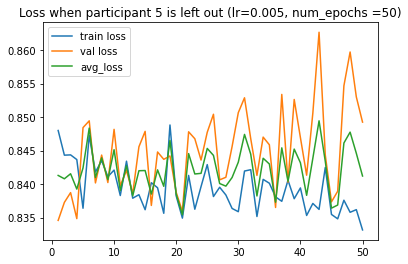

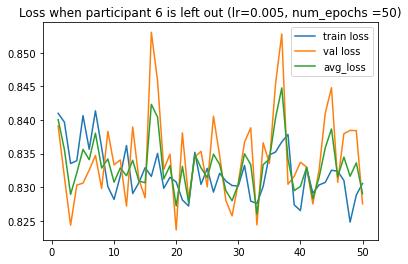

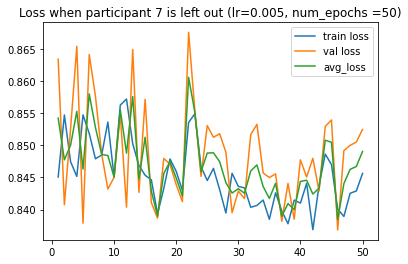

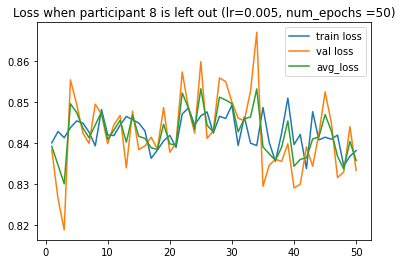

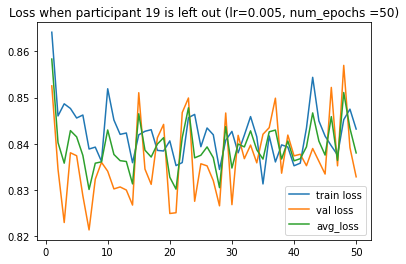

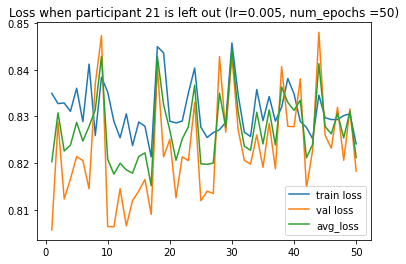

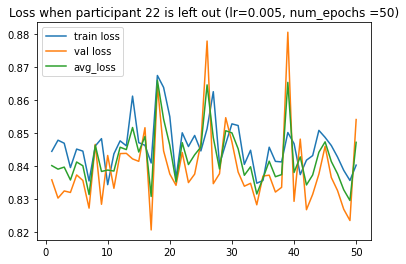

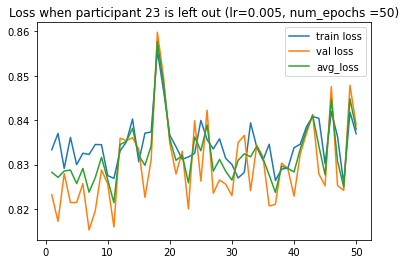

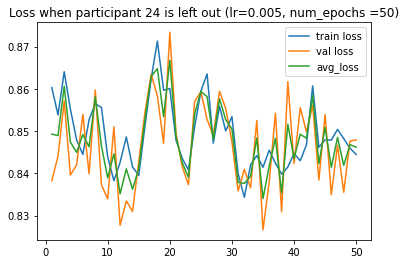

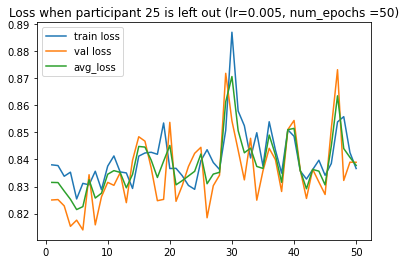

In [40]:
Linear_LOP0CV(complete_emg, model=Linear_emg_features_ratings(), num_folds=3, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num)
     

In [41]:
xdfgchvjbkn

NameError: name 'xdfgchvjbkn' is not defined

## Model 3 - LSTM + fully connected layers using all 180 features

In [ ]:
fcygvhbkjln

In [ ]:
hand_0.head(2)

In [ ]:
#hand_0.new_interaction_id.unique().tolist()#hand_0.iloc[:,11:].shape[1]#.slice_num.nunique()

In [ ]:
itr_id_df = hand_0[hand_0.new_interaction_id==1] 
itr_id_df.iloc[0,11:].values

In [ ]:
df_info = normalised_df.iloc[:,:11]
hand1_emg = normalised_df.iloc[:,35:59]
a = pd.concat([df_info, hand1_emg], axis=1)
print(a.shape)
b = normalised_df.iloc[:,:35]
print(b.shape)

In [ ]:
df_info.head(2)

In [ ]:
b.head(2)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [ ]:
# Add a column to interact

normalised_df.insert(5, "new_interaction_id", None)
normalised_df['new_interaction_id'] = normalised_df.groupby(['participant_id', 'clothes_id', 'property_id', 'sub_window_num'], sort=False).ngroup() + 1
normalised_df.head()


In [ ]:
# Obtain features for each hand
hand1_emg = normalised_df.iloc[:,35:59]

hand0_acc = normalised_df.iloc[:,59:86]
hand1_acc = normalised_df.iloc[:,86:113]

hand0_qua = normalised_df.iloc[:,113:152]
hand1_qua = normalised_df.iloc[:,152:]

df_info = normalised_df.iloc[:,:11]
# Combine the data to ceate a df for each hand
emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)

hand_0 = pd.concat([emg_0, hand0_acc, hand0_qua], axis=1)
hand_1 = pd.concat([df_info, hand1_emg, hand1_acc, hand1_qua], axis=1)

In [ ]:
print(hand_0.shape)
print(hand_1.shape)

print(emg_0.shape)
print(emg_1.shape)


### Create the model

In [ ]:
class LSTM_all_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_all_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(90+5, 40, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 40 * 2, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    


In [ ]:
def find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model):

    # Model
    train_model = model

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))

            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
     
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,3)}, val loss = {round(avg_validation_loss,3)}, average loss = {round(avg_loss,3)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV(data_0, data_1, model, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
        
    total_conf_mat = 0
    micro_f1_lst = []
    acc_lst = []
    if predicting_feature == 'property_id':
        macro_f1_lst = []
    elif predicting_feature == 'rating_level_num':
        weighted_f1_lst = [] 
        
        data0_add = create_y_train_for_2d_X(data_0, predicting_feature = 'property_id', output_as_tensor='No')
        data0_add_pd = pd.DataFrame(data0_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_0 = pd.concat([data_0.reset_index(drop=True), data0_add_pd.reset_index(drop=True)], axis=1)
        data1_add = create_y_train_for_2d_X(data_1, predicting_feature = 'property_id', output_as_tensor='No')
        data1_add_pd = pd.DataFrame(data1_add, columns = ['smoothness','thickness','warmth', 'flexibility', 'softness'])
        data_1 = pd.concat([data_1.reset_index(drop=True), data1_add_pd.reset_index(drop=True)], axis=1)
    
    for participant in sorted(data_0.participant_id.unique()): # # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11) 
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)           
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = predicting_feature)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = predicting_feature)        
 

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=y_test.shape[0]//4) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_3d_X(train_dataloader, val_dataloader, learning_rate, num_epochs, model)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = model
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()    
        
        if predicting_feature == 'property_id':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
            macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
            macro_f1_lst.append(macro_f1_score) 
        elif predicting_feature == 'rating_level_num':
            conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0,1,2])
            weighted_f1_score = f1_score(test_labels_np, test_predicted_np, average='weighted') 
            weighted_f1_lst.append(weighted_f1_score)
            
        total_conf_mat += conf_mat
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        micro_f1_lst.append(micro_f1_score)
        acc = accuracy_score(test_labels_np, test_predicted_np)
        acc_lst.append(acc)


        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        if predicting_feature == 'property_id':
            print(f"(3) Macro F1 score = {round(macro_f1_score,2)}")
        elif predicting_feature == 'rating_level_num':
            print(f"(3) Weighted F1 score = {round(weighted_f1_score,2)}")            
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    if predicting_feature == 'property_id':
        avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)  
    elif predicting_feature == 'rating_level_num':
        avg_weighted_f1_score = sum(weighted_f1_lst) / len(weighted_f1_lst)             
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    if predicting_feature == 'property_id':
        print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    elif predicting_feature == 'rating_level_num':
        print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            


### Run the model for properties

In [ ]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.085, num_epochs=50, random_state=num) #, num_inner_folds=5


### Run the model for ratings

In [ ]:
LSTM_LOP0CV(hand_0, hand_1, model=LSTM_all_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=50, random_state=num) #, num_inner_folds=5


## Model 4 - LSTM + fully connected layers using only the emg data (48 features)

complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,35:59]
hand0_emg.head()

In [ ]:
#hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,35:59]

emg_0 = normalised_df.iloc[:,:35]
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class LSTM_emg_features_properties(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    
class LSTM_emg_features_ratings(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(24+5, 15, 1, batch_first=True)
        self.fc1 = nn.Linear(3 * 15 * 2, 25)
        self.fc2 = nn.Linear(25, 10)
        self.fc3 = nn.Linear(10, 3)
          
    def forward(self, x1, x2): #, x2
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

### Run the model

In [ ]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_properties(), num_folds=5, predicting_feature='property_id', learning_rate=0.005, num_epochs=70, random_state=num) #, num_inner_folds=5



### Run the model for ratings

In [ ]:
LSTM_LOP0CV(emg_0, emg_1, model=LSTM_emg_features_ratings(), num_folds=5, predicting_feature='rating_level_num', learning_rate=0.005, num_epochs=70, random_state=num) #, num_inner_folds=5


In [ ]:
dtryftugyihuoi

In [ ]:
def find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = LSTM_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def LSTM_LOP0CV_properties_2(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data_0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_4(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = LSTM_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



In [ ]:
LSTM_LOP0CV_properties_2(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.05, num_epochs=70, random_state=num) 


In [ ]:
t2 = time.time()

## Model 5 - CNN + LSTM

In [ ]:
complete_emg = normalised_df.iloc[:,:59]
hand0_emg = normalised_df.iloc[:,43:51]
hand0_emg.head()

In [ ]:
hand0_emg = normalised_df.iloc[:,19:27]
hand1_emg = normalised_df.iloc[:,43:51]

emg_0 = pd.concat([df_info, hand0_emg], axis=1)
emg_1 = pd.concat([df_info, hand1_emg], axis=1)


### Create the model

In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0, groups=3) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(8, 4, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        self.fc1 = nn.Linear(3 * 4 * 2, 18)
        self.fc2 = nn.Linear(18, 10)
        self.fc3 = nn.Linear(10, 5)
          
    def forward(self, x1, x2): #, x2
        x1 = self.pool(F.tanh(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.tanh(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
m3 = CNN_LSTM()
print(m3)

In [ ]:
def find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)  
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def CNN_LSTM_LOP0CV_properties_1(data_0, data_1, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    lst = [6,24,2]#,24]
    
    for participant in lst: #sorted(data0.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data_0 = data_0[data_0.participant_id != participant] 
        training_data_1 = data_1[data_1.participant_id != participant] 
        testing_data_0 = data_0[data_0.participant_id == participant] 
        testing_data_1 = data_1[data_1.participant_id == participant] 

        # Data preparation
        X_train_0 = create_X_3d(training_data_0, 11)
        X_train_1 = create_X_3d(training_data_1, 11)        
        y_train = create_y_train_for_3d_X(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X_3d(testing_data_0, 11) 
        X_test_1 = create_X_3d(testing_data_1, 11)
        y_test = create_y_test_for_3d_X(testing_data_0, predicting_feature = 'property_id')
        #print(y_test)

        #print(X_train_0.shape)
        #print(X_train_1.shape)
        #print(y_train.shape)
        #print(X_test_0.shape)
        #print(X_test_1.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=30) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_3(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1, test_input2) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            



### Run the model

In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 



In [ ]:
CNN_LSTM_LOP0CV_properties_1(emg_0, emg_1, num_folds=5, predicting_feature='property_id', learning_rate=0.3, num_epochs=30, random_state=num) 


In [ ]:
t2 = time.time()

In [ ]:
def find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs):

    # Model
    train_model = Linear_model_2()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    #best_model_epoch_num = np.inf
    train_loss_lst = []
    val_loss_lst = []
    avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        epoch_train_loss = 0
        epoch_val_loss = 0
        avg_loss = 0
        #count_train = 0
        #count_val = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            #print(len(train_data))
            #count_train += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_labels = train_data #train_input2, 

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1) #, train_input2
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            epoch_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
               # count_val += 1
               # print(len(val_data))
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_labels = val_data # val_input2, 

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1) #, val_input2

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                epoch_val_loss += val_loss.item()
        #print(len(train_dataloader), len(val_dataloader))       
        avg_training_loss = epoch_train_loss / len(train_dataloader) #count_train
        avg_validation_loss = epoch_val_loss / len(val_dataloader) #count_val
        avg_loss = (avg_training_loss + avg_validation_loss) / 2
        
        train_loss_lst.append(avg_training_loss)
        val_loss_lst.append(avg_validation_loss)
        avg_loss_lst.append(avg_loss)
         
        #print(f'epoch {epoch+1}: train loss = {round(avg_training_loss,2)}, val loss = {round(avg_validation_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()

    return best_avg_loss, best_model, train_loss_lst, val_loss_lst, avg_loss_lst   #, avg_loss_lst, 


In [ ]:
# Original
def Linear_LOP0CV_properties_2(data, num_folds=5, predicting_feature='property_id', learning_rate=0.01, num_epochs=10, random_state=num, X_dim=2): #, num_inner_folds=5
    # Set fixed random number seed
    torch.manual_seed(num)
    
   # elif predicting_feature == 'rating_level_num':
    #weighted_f1_lst = [] 
    total_conf_mat = 0
    micro_f1_lst = []
    macro_f1_lst = []
    acc_lst = []

    #lst = [6,24,2]#,24]
    
    for participant in sorted(data.participant_id.unique()): # #:lst: #
        print(f'LEAVING PARTICIPANT {participant} OUT:')
        
        # Split the data into training and testing
        training_data = data[data.participant_id != participant] 
        testing_data = data[data.participant_id == participant] 

        # Data preparation
        if X_dim == 2:
            X_train = create_X_2d(training_data, 11)       
            y_train = create_y_train_for_2d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_2d(testing_data, 11) 
            y_test = create_y_test_for_2d_X(testing_data, predicting_feature = 'property_id')
        elif X_dim == 3:
            X_train = create_X_3d(training_data, 11)       
            y_train = create_y_train_for_3d_X(training_data, predicting_feature = 'property_id')
            X_test = create_X_3d(testing_data, 11) 
            y_test = create_y_test_for_3d_X(testing_data, predicting_feature = 'property_id')

        #print(X_train.shape)
        #print(y_train.shape)
        #print(X_test.shape)
        #print(y_test.shape)
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train, y_train) 
        
        test_dataset = TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=90) # num_workers=2,       
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
                
        min_avg_loss_subject = np.inf
        best_model_subject = None
        
        best_train_loss_lst = None
        best_val_loss_lst = None
        best_avg_loss_lst = None
        best_fold = np.inf

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            #print(f'FOLD {fold+1}:')
                       
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler) #, batch_size=100
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler) #, batch_size=20        

            avg_loss_fold, best_model_fold, fold_train_loss_lst, fold_val_loss_lst, fold_avg_loss_lst = find_best_model_for_fold_2(train_dataloader, val_dataloader, learning_rate, num_epochs)
                           
            if avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = avg_loss_fold
                best_model_subject = best_model_fold
                best_train_loss_lst = fold_train_loss_lst
                best_val_loss_lst = fold_val_loss_lst
                best_avg_loss_lst = fold_avg_loss_lst
                best_fold = fold+1

        fig = plt.figure(f"{participant}")                  
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_train_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_val_loss_lst)
        plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), best_avg_loss_lst)
        plt.title(f"Loss when participant {participant} is left out for fold {best_fold} (lr={learning_rate}, num_epochs ={num_epochs})")
        plt.legend(['train loss', 'val loss', 'avg_loss'])

        # save trained model 
        name = 'model_participant_'+str(participant)+'.pt'
        torch.save(best_model_subject, name)
        print(f'The model for participant {participant} has been saved')
        
        test_model = Linear_model_2()
        test_model.load_state_dict(torch.load(name))

        dataiter = iter(test_dataloader) 
        test_input1, test_labels = dataiter.next() 
    
        test_preds = test_model(test_input1) 
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        
        test_labels_np = test_labels.numpy()       
        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving participant {participant} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        total_conf_mat += conf_mat 
        micro_f1_lst.append(micro_f1_score)
        macro_f1_lst.append(macro_f1_score) 
        acc_lst.append(acc)
        print('--------------------------------')
        
    avg_micro_f1_score = sum(micro_f1_lst) / len(micro_f1_lst)
    avg_macro_f1_score = sum(macro_f1_lst) / len(macro_f1_lst)         
    avg_acc = sum(acc_lst) / len(acc_lst)   
    
    print(f'Using Leave One Participant Out CV (LOPOCV):') 
    print("(1) Confusion matrix:\n", total_conf_mat)
    print(f"(2) Average micro F1 score = {round(avg_micro_f1_score,2)}")
    #if predicting_feature == 'property_id':
    print(f"(3) Average macro F1 score = {round(avg_macro_f1_score,2)}")
    #elif predicting_feature == 'rating_level_num':
        #print(f"(3) Average weighted F1 score = {round(avg_weighted_f1_score,2)}")      
    print(f"(4) Average Percentage Classification accuracy = {round(avg_acc*100,2)}%")
            

